In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
from warnings import warn
from collections import namedtuple

import numpy
from scipy import constants
from scipy.optimize import least_squares, minimize, root_scalar
from matplotlib import pyplot as plt

In [3]:
def _warn_solution(name, target, result, threshold=0.02):
    err = numpy.abs((result - target) / target)
    if err > threshold:
        wmsg1 = "{:s} fit error of {:0.1f}% exceeds {:0.1f}% threshold."
        wmsg1 = wmsg1.format(name, err * 100, threshold * 100)
        wmsg2 = "Target={:0.3f}, Result={:0.3f}, Delta={:0.3f}"
        wmsg2 = wmsg2.format(target, result, result - target)
        msg = " ".join([wmsg1, wmsg2])
        warn(msg)

In [4]:
_metrics = namedtuple("metrics", "isc voc imp vmp pmp vi iv pv")

In [130]:
class array:
    def __init__(self, isc, voc, imp, vmp, t, ns, np):
        assert isc[0] > imp[0] and isc[1] > imp[1], "Isc must exceed Imp."
        assert voc[0] > vmp[0] and voc[1] > vmp[1], "Voc must exceed Vmp."
        assert t > -273.15, "Temperature must exceed absolute zero."
        assert ns > 0, "There must be atleast one cell per string."
        assert np > 0, "There must be atleast one string per array."

        self.isc = isc
        self.voc = voc
        self.imp = imp
        self.vmp = vmp
        self.t = t
        self.ns = numpy.ceil(ns)
        self.np = numpy.ceil(np)

    def params(self, t, g):
        assert t > -273.15, "Temperature must exceed absolute zero."
        assert g >= 0, "Intensity must be non-negative."

        # Compute the adjusted cell parameters.
        dt = t - self.t
        isc = (self.isc[0] + dt * self.isc[1]) * g
        voc = self.voc[0] + dt * self.voc[1]
        imp = (self.imp[0] + dt * self.imp[1]) * g
        vmp = self.vmp[0] + dt * self.vmp[1]

        return isc, voc, imp, vmp

    def cell(self, t, g):
        isc, voc, imp, vmp = self.params(t, g)
        pmp = imp * vmp

        if g == 0:
            xvi = lambda i: 0
            xiv = lambda v: numpy.inf if v < 0 else 0
            xpv = lambda v: v * xiv(v)
            return _metrics(isc, voc, imp, vmp, pmp, xvi, xiv, xpv)

        q_kT = constants.e / (constants.k * (t + 273.15))

        def x2eqn(x):
            # Diode model is a logarithmic function, V=F(I).
            i0, rs, n = x  # Parameters to be solved for numerically.
            i0 = i0 * 1e-20  # Scale factor to assist solver.
            q_nkT = q_kT / n

            def v(i):
                with numpy.errstate(invalid="ignore"):
                    vraw = numpy.log((isc - i) / i0 + 1) / q_nkT - i * rs
                    vraw = numpy.nan_to_num(vraw)  # Bypass diode.
                    vraw = numpy.where(i < 0, numpy.nan, vraw)  # Blocking diode.
                    return vraw

            return v

        def x2params(x):
            # Numerically invert the diode model to solve for Isc/Imp.
            v = x2eqn(x)
            risc = root_scalar(f=v, x0=isc, bracket=(isc * 0.98, isc))
            rimp = minimize(
                fun=lambda ximp: 1 / (ximp * v(ximp)),
                x0=isc / 2,
                bounds=[(0, isc * 0.99)],
            )
            assert risc.converged and rimp.success

            # Return the cell parameters: (xisc, xvoc, ximp, xvmp).
            return risc.root, v(0), rimp.x[0], v(rimp.x[0])

        def minfun(x):
            # The IV-curve is optimized againt Voc, Vmp, and Pmp.
            _, xvoc, ximp, xvmp = x2params(x)
            return voc - xvoc, vmp - xvmp, pmp - (ximp * xvmp)

        result = least_squares(
            fun=minfun,
            x0=(1, 0.1, 2.5),
            bounds=((1e-3, 0, 0.1), (1e3, 1, 10)),
            xtol=None,
        )
        emsg = "Curve fit failed for cell(t={:0.1f}, g={:0.2f})."
        assert result.success and result.cost < 0.01, emsg.format(t, g)

        # Warn if the solution is a poor fit.
        xisc, xvoc, ximp, xvmp = x2params(result.x)
        _warn_solution("Isc", isc, xisc)
        _warn_solution("Voc", voc, xvoc)
        _warn_solution("Imp", imp, ximp)
        _warn_solution("Vmp", vmp, xvmp)

        # Interpolate over voltage.
        xvi = lambda i: x2eqn(result.x)(i)
        i = numpy.linspace(0, xisc, 1000)
        xv = numpy.linspace(0, xvoc, 1000)
        xi = numpy.interp(xv, xvi(i)[::-1], i[::-1])
        xiv = lambda v: numpy.interp(v, xv, xi, left=numpy.inf, right=0)
        xpv = lambda v: v * xiv(v)

        return _metrics(xisc, xvoc, ximp, xvmp, ximp * xvmp, xvi, xiv, xpv)

    def curve(self, t, g):
        pass

In [131]:
# Azur Space 3G30A triple-junction solar cells in a 24s12p configuration.
# Isc/Imp are specified in (A, A/C), Voc/Vmp are specified in (V, V/C).
# Temperature is specified in C. Intensity is unitless and scales Isc/Imp.
array = array(
    isc=(0.5196, 0.00036),  # short-circuit current, temp coefficient
    voc=(2.690, -0.0062),  # open-circuit voltage, temp coefficient
    imp=(0.5029, 0.00024),  # max-power current, temp coefficient
    vmp=(2.409, -0.0067),  # max-power voltage, temp coefficient
    t=28,  # temperature at which the above parameters are specified
    ns=24,  # number of series cells in a string
    np=12,  # number of parallel strings in an array
)

In [132]:
array.params(t=80, g=1)

(0.5383199999999999, 2.3676, 0.5153800000000001, 2.0606)

In [133]:
cell = array.cell(t=60, g=1)
cell.vi(6)

array(0.)

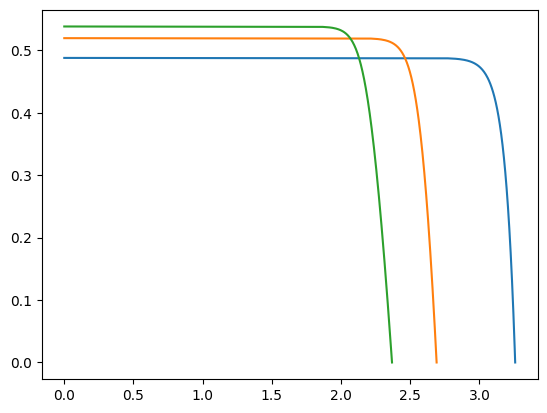

In [134]:
for t in [-60, 28, 80]:
    cell = array.cell(t=t, g=1)
    v = numpy.linspace(0, cell.voc, 1000)
    plt.plot(v, cell.iv(v))

In [4]:
curve = array.curve(t=80, g=1)